In [58]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, cross_val_score, train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [59]:
#Reading data from csv
Cycles_df = pd.read_csv('ny_cyclists_new.csv', encoding='ISO-8859-1')
Cycles_df.head(10)

,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total
0,1-Apr,Saturday,46.0,37.0,0,606,"1,446","1,915","1,430","5,397"
1,2-Apr,Sunday,62.1,41.0,0,"2,021","3,943","4,207","2,862","13,033"
2,3-Apr,Monday,63.0,50.0,0.03,"2,470","4,988","5,178","3,689","16,325"
3,4-Apr,Tuesday,51.1,46.0,1.18,723,"1,913","2,279","1,666","6,581"
4,5-Apr,Wednesday,63.0,46.0,0,"2,807","5,276","5,711","4,197","17,991"
5,6-Apr,Thursday,48.9,41.0,0.73,461,"1,324","1,739","1,372","4,896"
6,7-Apr,Friday,48.0,43.0,T,"1,222","2,955","3,399","2,765","10,341"
7,8-Apr,Saturday,55.9,39.9,0,"1,674","3,163","4,082","2,691","11,610"
8,9-Apr,Sunday,66.0,45.0,0,"2,375","4,377","4,886","3,261","14,899"
9,10-Apr,Monday,73.9,55.0,0,"3,324","6,359","6,881","4,731","21,295"


In [60]:
Cycles_df=Cycles_df[['Day', 'High Temp (°F)', 'Low Temp (°F)', 'Precipitation',
       'Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge',
       'Queensboro Bridge', 'Total']]

In [61]:
Cycles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Day                  214 non-null    object 
 1   High Temp (°F)       214 non-null    float64
 2   Low Temp (°F)        214 non-null    float64
 3   Precipitation        214 non-null    object 
 4   Brooklyn Bridge      214 non-null    object 
 5   Manhattan Bridge     214 non-null    object 
 6   Williamsburg Bridge  214 non-null    object 
 7   Queensboro Bridge    214 non-null    object 
 8   Total                214 non-null    object 
dtypes: float64(2), object(7)
memory usage: 15.2+ KB


In [62]:
#Generating a new feature "Mean Temp (°F)" as an average of "High Temp (°F)" and "Low Temp (°F)"
Cycles_df['Mean Temp (°F)'] = (Cycles_df['High Temp (°F)'] + Cycles_df['Low Temp (°F)'] ) / 2

In [63]:
#Replacing constant values in "Precipitation" column to nan to know the total missing/unknown values
Cycles_df['Precipitation']=Cycles_df['Precipitation'].replace('T',np.nan)

In [64]:
#class_mapping = {label: idx for idx, label in enumerate(np.unique(Cycles_df['Day']))}
#class_mapping
#Cyles_df['Day'] = Cycles_df['Day'].map(class_mapping)

# Manual numerical encoding of the values of the week instead random numerical encoding to understand the trend.
Cycles_df = Cycles_df.replace({'Day': {'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday': 7}})
Cycles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Day                  214 non-null    int64  
 1   High Temp (°F)       214 non-null    float64
 2   Low Temp (°F)        214 non-null    float64
 3   Precipitation        200 non-null    object 
 4   Brooklyn Bridge      214 non-null    object 
 5   Manhattan Bridge     214 non-null    object 
 6   Williamsburg Bridge  214 non-null    object 
 7   Queensboro Bridge    214 non-null    object 
 8   Total                214 non-null    object 
 9   Mean Temp (°F)       214 non-null    float64
dtypes: float64(3), int64(1), object(6)
memory usage: 16.8+ KB


In [65]:
Cycles_df.index=pd.date_range('2017-04-01',periods=len(Cycles_df), freq='D')
Cycles_df.head()

,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total,Mean Temp (°F)
2017-04-01,7,46.0,37.0,0,606,"1,446","1,915","1,430","5,397",41.50
2017-04-02,1,62.1,41.0,0,"2,021","3,943","4,207","2,862","13,033",51.55
2017-04-03,2,63.0,50.0,0.03,"2,470","4,988","5,178","3,689","16,325",56.50
2017-04-04,3,51.1,46.0,1.18,723,"1,913","2,279","1,666","6,581",48.55
2017-04-05,4,63.0,46.0,0,"2,807","5,276","5,711","4,197","17,991",54.50


In [66]:
Cycles_df.reset_index(inplace=True)
Cycles_df = Cycles_df.rename(columns = {'index':'Date'})

In [67]:
QB_cycles_df=Cycles_df[['Date', 'Day', 'High Temp (°F)', 'Low Temp (°F)', 'Precipitation', 'Mean Temp (°F)',
       'Queensboro Bridge']]

In [68]:
QB_cycles_df.head(3)

,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Mean Temp (°F),Queensboro Bridge
0,2017-04-01,7,46.0,37.0,0,41.50,"1,430"
1,2017-04-02,1,62.1,41.0,0,51.55,"2,862"
2,2017-04-03,2,63.0,50.0,0.03,56.50,"3,689"


In [69]:
# make a list of the variables that contain missing/constant values
vars_with_na = [var for var in Cycles_df.columns if Cycles_df[var].isnull().sum() > 0]

# determine percentage of missing values
QB_cycles_df[vars_with_na].isnull().mean()

Precipitation    0.065421
dtype: float64

In [70]:
#Updating data types and replacing commas in the numbers
QB_cycles_df["Precipitation"] = pd.to_numeric(QB_cycles_df["Precipitation"], downcast="float")
QB_cycles_df['Queensboro Bridge']=QB_cycles_df['Queensboro Bridge'].str.replace(',', '').astype(int)
QB_cycles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               214 non-null    datetime64[ns]
 1   Day                214 non-null    int64         
 2   High Temp (°F)     214 non-null    float64       
 3   Low Temp (°F)      214 non-null    float64       
 4   Precipitation      200 non-null    float32       
 5   Mean Temp (°F)     214 non-null    float64       
 6   Queensboro Bridge  214 non-null    int32         
dtypes: datetime64[ns](1), float32(1), float64(3), int32(1), int64(1)
memory usage: 10.2 KB


C:\Users\Public\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Public\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


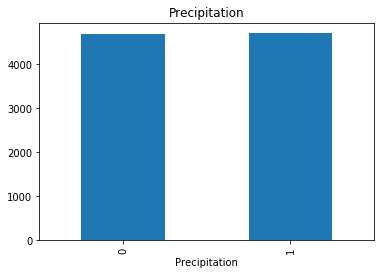

In [71]:
def analyse_na_value(df, var):

    df = df.copy()

    # let's make a variable that indicates 1 if the observation was missing or zero otherwise
    df[var] = np.where(df[var].isnull(), 1, 0)

    # let's compare the median Cyclist count in the observations where data is missing
    # vs the observations where a value is available

    df.groupby(var)['Queensboro Bridge'].median().plot.bar()

    plt.title(var)
    plt.show()


# let's run the function on each variable with missing data
for var in vars_with_na:
    analyse_na_value(QB_cycles_df, var)

In [72]:
#Replacing the missing/constant values with the average of the column since the missing values have not much significance on the outcome
QB_cycles_df['Precipitation'].fillna(float(QB_cycles_df['Precipitation'].mean()), inplace=True)

C:\Users\Public\Anaconda\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [73]:
QB_cycles_df.head(10)

,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Mean Temp (°F),Queensboro Bridge
0,2017-04-01,7,46.0,37.0,0.000,41.50,1430
1,2017-04-02,1,62.1,41.0,0.000,51.55,2862
2,2017-04-03,2,63.0,50.0,0.030,56.50,3689
3,2017-04-04,3,51.1,46.0,1.180,48.55,1666
4,2017-04-05,4,63.0,46.0,0.000,54.50,4197
5,2017-04-06,5,48.9,41.0,0.730,44.95,1372
6,2017-04-07,6,48.0,43.0,0.141,45.50,2765
7,2017-04-08,7,55.9,39.9,0.000,47.90,2691
8,2017-04-09,1,66.0,45.0,0.000,55.50,3261
9,2017-04-10,2,73.9,55.0,0.000,64.45,4731


In [74]:
# make list of numerical variables
num_vars = [var for var in QB_cycles_df.columns if QB_cycles_df[var].dtypes != 'O']

print('Number of numerical variables: ', len(num_vars))

# visualise the numerical variables
QB_cycles_df[num_vars].head()

Number of numerical variables:  7


,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Mean Temp (°F),Queensboro Bridge
0,2017-04-01,7,46.0,37.0,0.00,41.50,1430
1,2017-04-02,1,62.1,41.0,0.00,51.55,2862
2,2017-04-03,2,63.0,50.0,0.03,56.50,3689
3,2017-04-04,3,51.1,46.0,1.18,48.55,1666
4,2017-04-05,4,63.0,46.0,0.00,54.50,4197


In [75]:
# Making list of discrete variables
discrete_vars = [var for var in num_vars if len(
    QB_cycles_df[var].unique()) < 25]


print('Number of discrete variables: ', len(discrete_vars), discrete_vars)

Number of discrete variables:  1 ['Day']


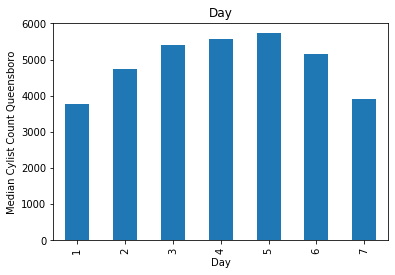

In [76]:
#Analyzing the distribution of Median Cyslist count on each week day
def analyse_discrete(df, var):
    df = df.copy()
    df.groupby(var)['Queensboro Bridge'].median().plot.bar()
    plt.title(var)
    plt.ylabel('Median Cylist Count Queensboro')
    plt.show()
    
for var in discrete_vars:
    analyse_discrete(QB_cycles_df, var)

In [77]:
# making list of continuous variables
cont_vars = [
    var for var in num_vars if var not in discrete_vars]

print('Number of continuous variables: ', len(cont_vars), cont_vars)

Number of continuous variables:  6 ['Date', 'High Temp (°F)', 'Low Temp (°F)', 'Precipitation', 'Mean Temp (°F)', 'Queensboro Bridge']


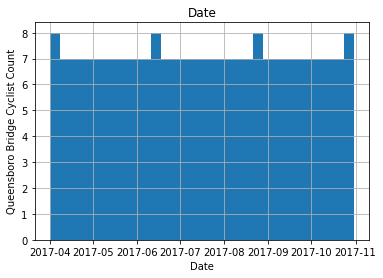

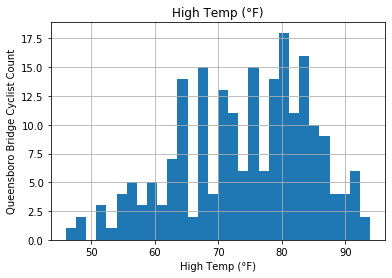

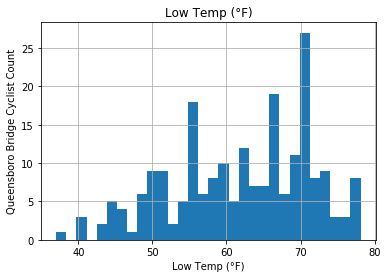

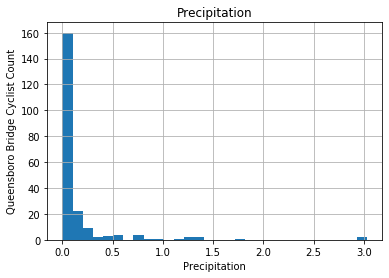

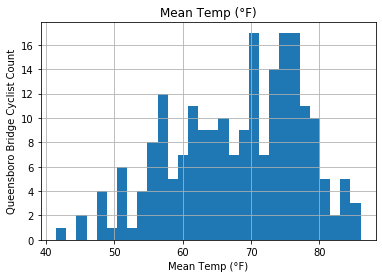

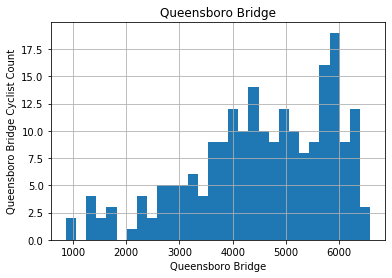

In [78]:
#Analyzing continuos variables and their relationship with Cyclist count
def analyse_continuous(df, var):
    df = df.copy()
    df[var].hist(bins=30)
    plt.ylabel('Queensboro Bridge Cyclist Count')
    plt.xlabel(var)
    plt.title(var)
    plt.show()


for var in cont_vars:
    analyse_continuous(QB_cycles_df, var)

Text(0.5, 1.0, 'Change in Cyclist Count by high temperature')

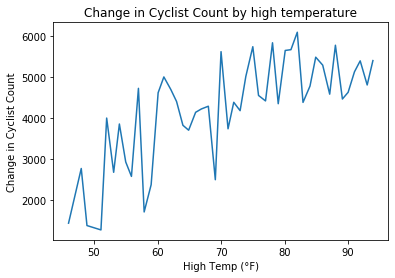

In [79]:
QB_cycles_df.groupby('High Temp (°F)')['Queensboro Bridge'].median().plot()
plt.ylabel('Change in Cyclist Count')
plt.title('Change in Cyclist Count by high temperature')

Text(0.5, 1.0, 'Change in Cyclist Count by low temperature')

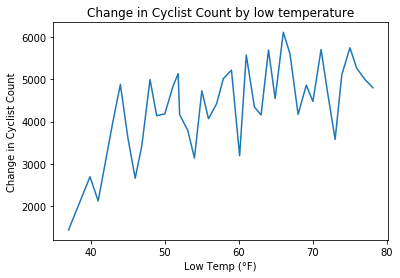

In [80]:
QB_cycles_df.groupby('Low Temp (°F)')['Queensboro Bridge'].median().plot()
plt.ylabel('Change in Cyclist Count')
plt.title('Change in Cyclist Count by low temperature')

Text(0.5, 1.0, 'Change in Cyclist Count by mean temperature')

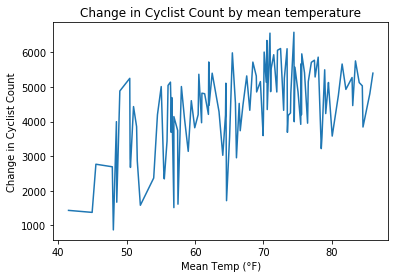

In [81]:
QB_cycles_df.groupby('Mean Temp (°F)')['Queensboro Bridge'].median().plot()
plt.ylabel('Change in Cyclist Count')
plt.title('Change in Cyclist Count by mean temperature')

Text(0.5, 1.0, 'Change in Cyclist Count by precipitation')

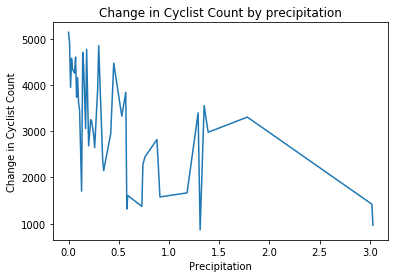

In [82]:
QB_cycles_df.groupby('Precipitation')['Queensboro Bridge'].median().plot()
plt.ylabel('Change in Cyclist Count')
plt.title('Change in Cyclist Count by precipitation')

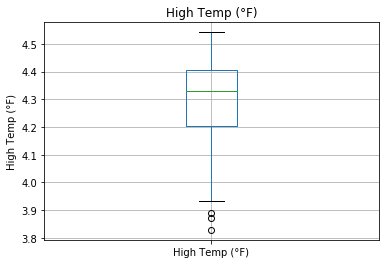

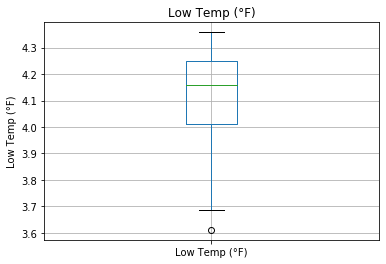

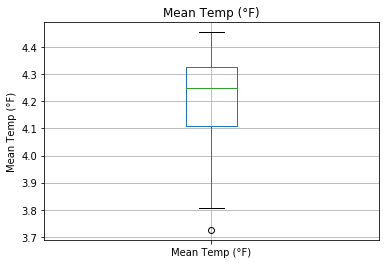

In [83]:
#Finding outliers
def find_outliers(df, var):
    df = df.copy()

    # log does not take negative values, so let's be
    # careful and skip those variables
    if any(QB_cycles_df[var] <= 0):
        pass
    else:
        df[var] = np.log(df[var])
        df.boxplot(column=var)
        plt.title(var)
        plt.ylabel(var)
        plt.show()


for var in cont_vars:
    if var!='Date' and var!='Queensboro Bridge':
        find_outliers(QB_cycles_df, var)
# There are very few outliers. Considering the low volume of data we have we will consume the entire dataset

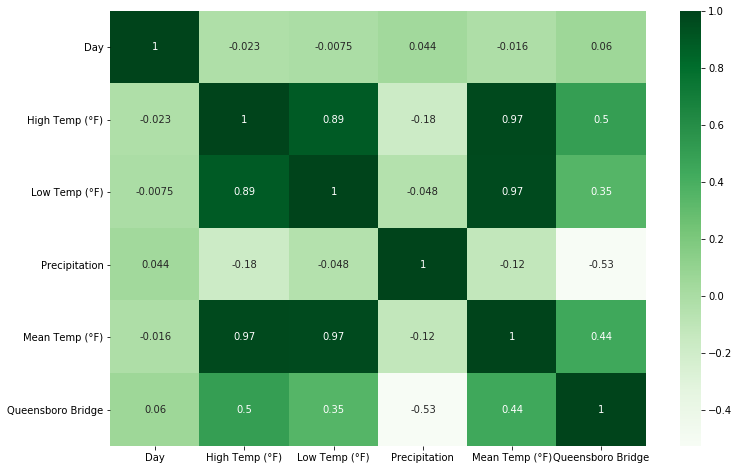

In [84]:
#Plotting the correlation matrix
import seaborn as sns
corr = QB_cycles_df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="Greens",annot=True)
# As per result below, we can use just the "High Temp", "Precipitation". 
# No need to use "low temp", "Mean temp" as they are highly corrrelated with feature variable "High Temp"
# No need to use "Day" as it has very less correlation with target variable - "Queensboro Bridge"

-------------Date--------------
Queensboro Bridge  865   965   1316  1372  1421  1430  1578  1609  1666  1704  \
Date                                                                            
2017-04-01            0     0     0     0     0     1     0     0     0     0   
2017-04-02            0     0     0     0     0     0     0     0     0     0   
2017-04-03            0     0     0     0     0     0     0     0     0     0   
2017-04-04            0     0     0     0     0     0     0     0     1     0   
2017-04-05            0     0     0     0     0     0     0     0     0     0   
...                 ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2017-10-27            0     0     0     0     0     0     0     0     0     0   
2017-10-28            0     0     0     0     0     0     0     0     0     0   
2017-10-29            0     1     0     0     0     0     0     0     0     0   
2017-10-30            0     0     0     0     0     0     0     0     0     0

Queensboro Bridge  865   965   1316  1372  1421  1430  1578  1609  1666  1704  \
Low Temp (°F)                                                                   
37.0                  0     0     0     0     0     1     0     0     0     0   
39.9                  0     0     0     0     0     0     0     0     0     0   
41.0                  0     0     0     1     0     0     0     0     0     0   
43.0                  0     0     0     0     0     0     0     0     0     0   
44.0                  0     0     0     0     0     0     0     0     0     0   
45.0                  1     0     0     0     0     0     0     0     0     0   
46.0                  0     0     0     0     0     0     0     0     1     0   
46.9                  0     0     0     0     0     0     0     0     0     0   
48.0                  0     0     0     0     0     0     0     0     0     0   
48.9                  0     0     0     0     0     0     0     0     0     0   
50.0                  0     

Queensboro Bridge  865   965   1316  1372  1421  1430  1578  1609  1666  1704  \
Mean Temp (°F)                                                                  
41.50                 0     0     0     0     0     1     0     0     0     0   
44.95                 0     0     0     1     0     0     0     0     0     0   
45.50                 0     0     0     0     0     0     0     0     0     0   
47.90                 0     0     0     0     0     0     0     0     0     0   
48.05                 1     0     0     0     0     0     0     0     0     0   
...                 ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
84.00                 0     0     0     0     0     0     0     0     0     0   
84.45                 0     0     0     0     0     0     0     0     0     0   
84.55                 0     0     0     0     0     0     0     0     0     0   
85.55                 0     0     0     0     0     0     0     0     0     0   
86.00                 0     

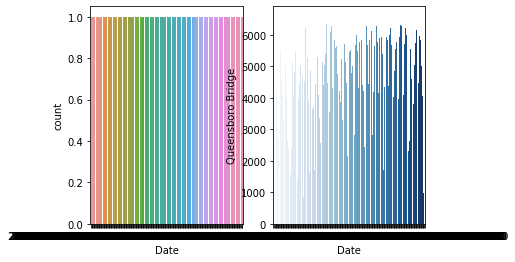

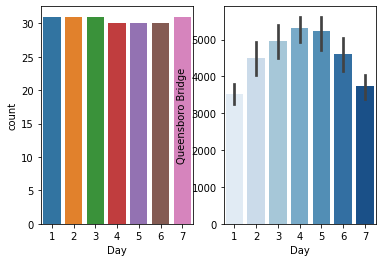

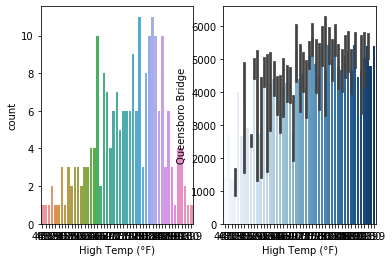

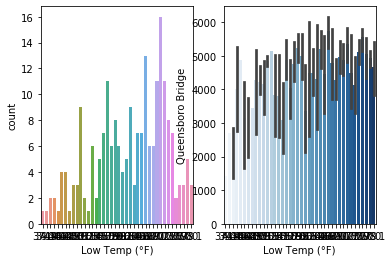

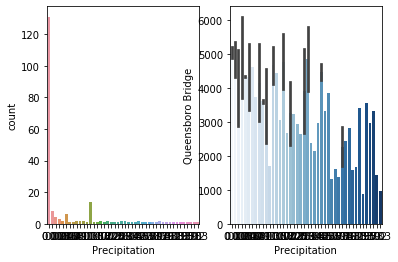

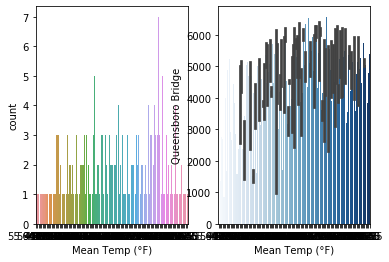

In [85]:
#Calculating the p-value between feature and target variables to understand the relationship
from scipy.stats import chi2, chi2_contingency
def explore_attribute(df, var):
    print('-------------%s--------------' %var)
    f, axes = plt.subplots(1,2)
    sns.countplot(x=var, data=df[[var,'Queensboro Bridge']], ax=axes[0])
    
    sns.barplot(x=var,y='Queensboro Bridge', palette = 'Blues', data=df[[var, 'Queensboro Bridge']], ax=axes[1])
    
    contingency = pd.crosstab(df[var],df['Queensboro Bridge'])
    print(contingency)
    c,p,dof,expected = chi2_contingency(contingency)
    print('p-value = %s' %p)
    if p<=0.05:
        print('Include this variable')
    else:
        print('Do not include this vairable')
    print('----------------------------End-----------------------------')

for var in QB_cycles_df.columns:
    if var!='Queensboro Bridge':
        explore_attribute(QB_cycles_df, var)

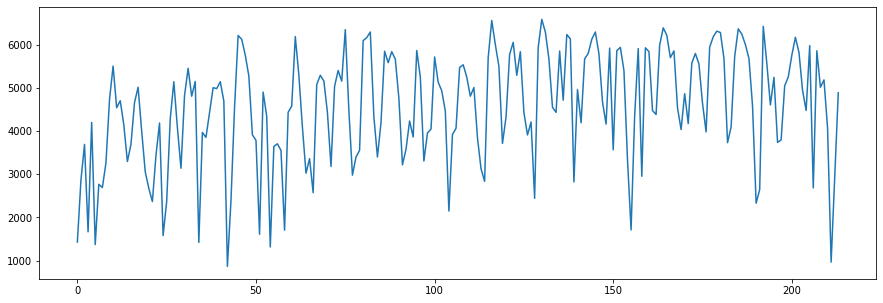

In [86]:
#Plotting the trend and seasonality of cyclist count
QB_cycles_df['Queensboro Bridge'].plot(figsize=(15,5))
#BB_cycles_df.info()

In [87]:
#Rolling mean and Rolling Std  
rolmean = QB_cycles_df['Queensboro Bridge'].rolling(window=12).mean() 
rolstd = QB_cycles_df['Queensboro Bridge'].rolling(window=12).std()
rolmean

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
          ...     
209    5178.916667
210    5097.583333
211    4740.583333
212    4504.833333
213    4397.833333
Name: Queensboro Bridge, Length: 214, dtype: float64

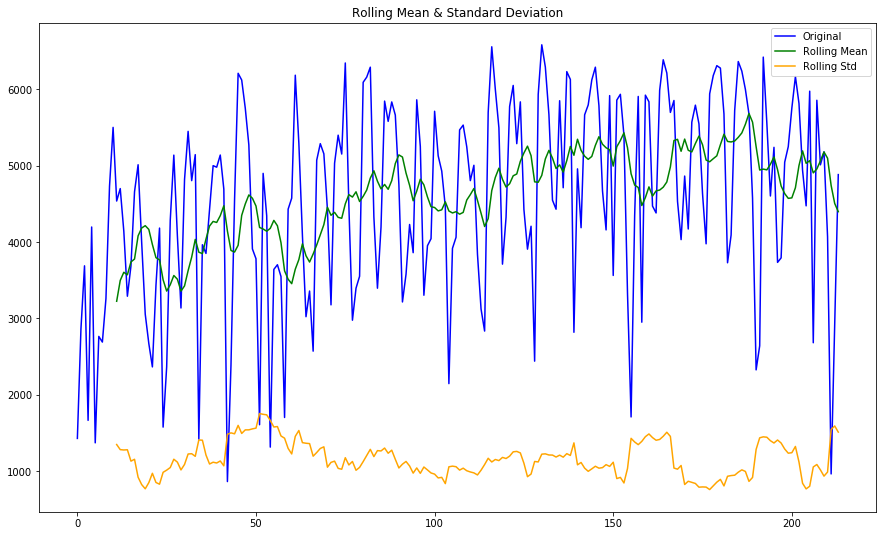

In [88]:
plt.figure(figsize=(15,9))
orig = plt.plot(QB_cycles_df['Queensboro Bridge'], color='blue', label='Original')
mean = plt.plot(rolmean, color='green', label='Rolling Mean')
std = plt.plot(rolstd, color='orange', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [89]:
#Seasonal First Difference
QB_cycles_df['Seasonal First Difference']=QB_cycles_df['Queensboro Bridge']-QB_cycles_df['Queensboro Bridge'].shift(1)

C:\Users\Public\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [90]:
QB_cycles_df.head(10)

,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Mean Temp (°F),Queensboro Bridge,Seasonal First Difference
0,2017-04-01,7,46.0,37.0,0.000,41.50,1430,NaN
1,2017-04-02,1,62.1,41.0,0.000,51.55,2862,1432.0
2,2017-04-03,2,63.0,50.0,0.030,56.50,3689,827.0
3,2017-04-04,3,51.1,46.0,1.180,48.55,1666,-2023.0
4,2017-04-05,4,63.0,46.0,0.000,54.50,4197,2531.0
5,2017-04-06,5,48.9,41.0,0.730,44.95,1372,-2825.0
6,2017-04-07,6,48.0,43.0,0.141,45.50,2765,1393.0
7,2017-04-08,7,55.9,39.9,0.000,47.90,2691,-74.0
8,2017-04-09,1,66.0,45.0,0.000,55.50,3261,570.0
9,2017-04-10,2,73.9,55.0,0.000,64.45,4731,1470.0


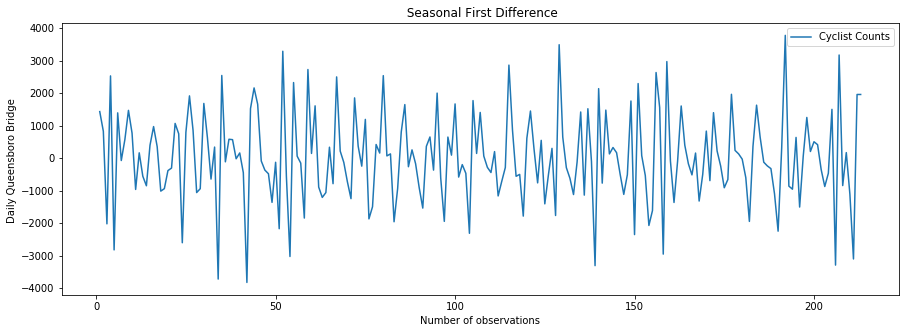

In [91]:
plt.xlabel('Number of observations')
plt.ylabel("Daily Queensboro Bridge ")
plt.title(" Seasonal First Difference") 
QB_cycles_df['Seasonal First Difference'].plot(figsize=(15, 5) , label = "Cyclist Counts" ) 
plt.legend(loc='best')
plt.show()

C:\Users\Public\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


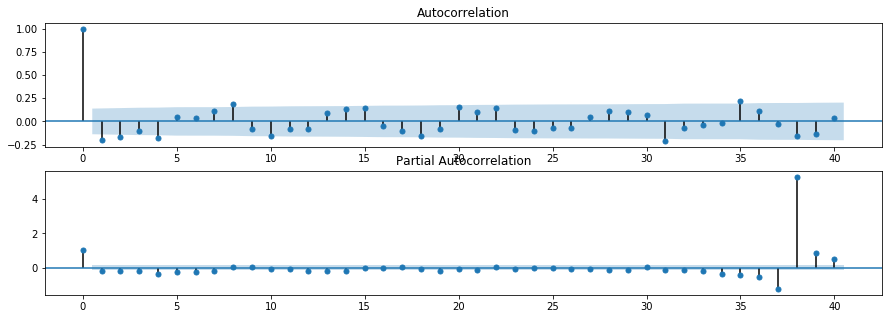

In [92]:
#Auto Correlation and Partial Autocorrelation Graphs
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(QB_cycles_df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(QB_cycles_df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

In [110]:
#Data is stationary from above charts, but it can can be confirmed with the Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
ad_fuller_result = adfuller(QB_cycles_df['Queensboro Bridge'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
if ad_fuller_result[1]<=0.05:
    print ('Reject Null Hypothesis Theory, Data is stationary')
else:
    print('Fail to Reject Null Hypothesis Theory, Data is non-stationary')

ADF Statistic: -2.1948985342943765
p-value: 0.2081022021463777
Fail to Reject Null Hypothesis Theory, Data is non-stationary


In [109]:
#Data is stationary from above charts, but it can can be confirmed with the Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
ad_fuller_result = adfuller(QB_cycles_df['Seasonal First Difference'].dropna())
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
if ad_fuller_result[1]<=0.05:
    print ('Reject Null Hypothesis Theory, Data is stationary')
else:
    print('Fail to Reject Null Hypothesis Theory, Data is non-stationary')

ADF Statistic: -7.694693651706473
p-value: 1.3893138827223481e-11
Reject Null Hypothesis Theory, Data is stationary


In [94]:
# As per the correlation matrix, we can use both the "High_temp" and "Precipitation".
# As per 'p-value' none of the exogeneous features can be used.
# We will use both the parameters as features variables going by the correlation results
#Fitting data with SARimax algorithm
model=sm.tsa.statespace.SARIMAX(QB_cycles_df['Queensboro Bridge'],exog = QB_cycles_df[['High Temp (°F)','Precipitation']],order=(2,0,3),seasonal_order=(2,0,3,7) )
model_fit=model.fit() 

C:\Users\Public\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\Public\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


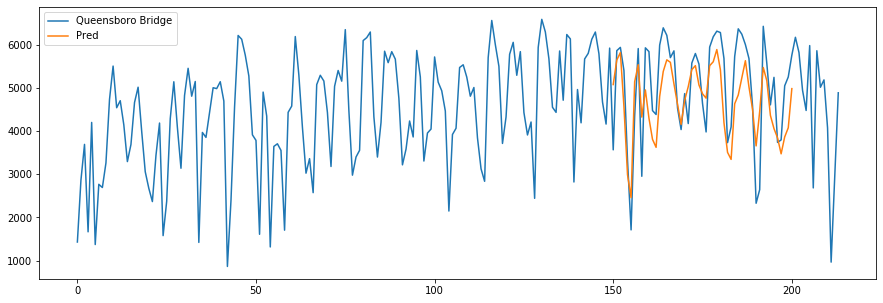

In [95]:
#Plotting the actual and prediction trend within portion of training data
QB_cycles_df['Pred'] = model_fit.predict(start = 150 , end = 200 , dynamic =True) 
QB_cycles_df[['Queensboro Bridge','Pred']].plot(figsize=(15,5))

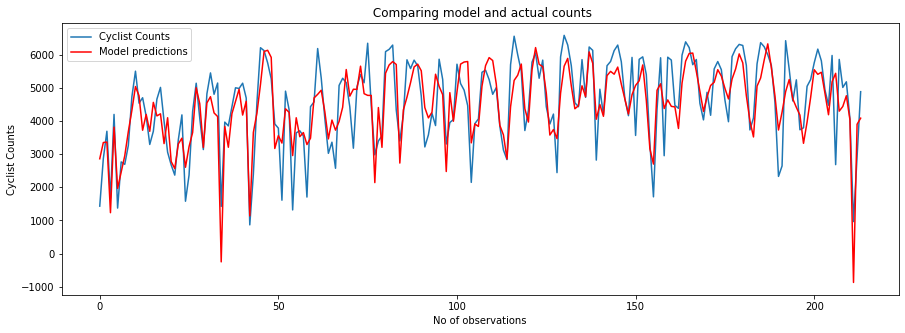

In [96]:
#Plotting the actual and prediction trend for the entire data taking lag into account
plt.xlabel('No of observations')
plt.ylabel('Cyclist Counts')
plt.title(" Comparing model and actual counts") 
QB_cycles_df['Queensboro Bridge'].plot(figsize=(15, 5) , label = 'Cyclist Counts' )
model_fit.fittedvalues.plot(figsize=(15, 5), color = 'red',label = 'Model predictions')    
plt.legend(loc='best')
plt.show()

In [97]:
#Printing 
pred_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print(pred_ARIMA_diff.head(10))

0    2858.791939
1    3349.050581
2    3363.438347
3    1232.434701
4    3813.846851
5    1965.355268
6    2458.226525
7    2949.240455
8    3679.129143
9    4321.080163
dtype: float64


In [98]:
#Predicted cumulative sum of bycycle count
pred_ARIMA_diff_cumsum = pred_ARIMA_diff.cumsum()
print(pred_ARIMA_diff_cumsum)

0        2858.791939
1        6207.842519
2        9571.280866
3       10803.715568
4       14617.562419
           ...      
209    945236.658088
210    949270.583764
211    948398.922100
212    952298.651342
213    956382.463874
Length: 214, dtype: float64


In [99]:
#RMSE
from sklearn.metrics import mean_squared_error 
import numpy as np

value1 = QB_cycles_df['Queensboro Bridge']
value2 =pred_ARIMA_diff 
np.sqrt(mean_squared_error(value1,value2))

759.7886249084586

In [100]:
#MAPE
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100
mape(value1,value2)

17.144562201448945

In [101]:
predictions=model_fit.forecast(steps=214 ,exog =  QB_cycles_df[['High Temp (°F)','Precipitation']])

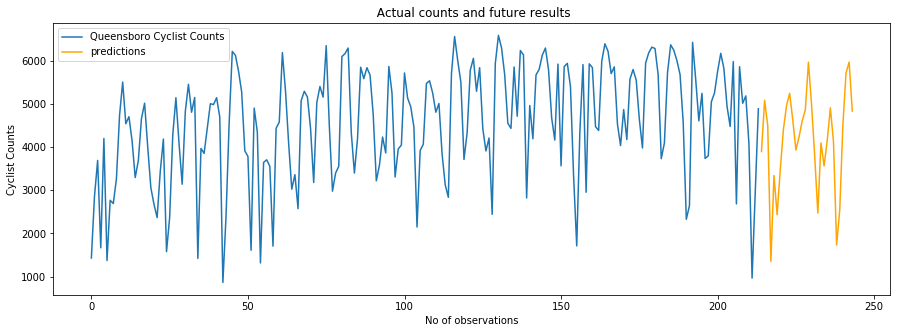

In [102]:
plt.xlabel('No of observations')
plt.ylabel('Cyclist Counts')
plt.title("  Actual counts and future results ") 
QB_cycles_df['Queensboro Bridge'].plot(figsize=(15, 5) , label = 'Queensboro Cyclist Counts')
predictions[0:30].plot(figsize=(15, 5),color = 'orange', label = 'predictions') 
plt.legend(loc='best')

In [103]:
Nov_QB_Sum=predictions[0:30].sum()
print(Nov_QB_Sum)
Oct_QB_Sum=(QB_cycles_df[(QB_cycles_df['Date']>='2017-10-01') & (QB_cycles_df['Date']<='2017-10-31')])['Queensboro Bridge'].sum()
print(Oct_QB_Sum)

124210.11117119946
147971


In [104]:
change=int(Nov_QB_Sum-Oct_QB_Sum)
change_perc=float(change/Oct_QB_Sum*100)
print("Cyclist Volume at Queensboro Bridge will change by %d for the month of November" % change)
print("Cyclist Percentage at Queensboro Bridge will change by %d percentage for the month of November" % change_perc)

Cyclist Volume at Queensboro Bridge will change by -23760 for the month of November
Cyclist Percentage at Queensboro Bridge will change by -16 percentage for the month of November


In [105]:
#Saving the results into csv file 
file1 = predictions[0:30].to_csv('Queensboro_Bridge_Predictions.csv')

In [106]:
#RMSE
from sklearn.metrics import mean_squared_error 
import numpy as np

value1 = QB_cycles_df['Queensboro Bridge']
value2 =pred_ARIMA_diff 
QB_MSE=mean_squared_error(value1,value2)

In [107]:
from math import log
def calculate_aic(n, mse, num_params):
    aic = n * log(mse) + 2 * num_params
    return aic
calculate_aic(214,QB_MSE,3)

2844.9412353357125

In [108]:
from math import log
# calculate bic for regression
def calculate_bic(n, mse, num_params):
    bic = n * log(mse) + num_params * log(n)
    return bic
calculate_bic(214,QB_MSE,3)

2855.039163380778